     user               first_open  dayofweek       hour  age  \
0  235136  2012-12-27 02:14:51.273          3   02:00:00   23   
1  333588  2012-12-02 01:16:00.905          6   01:00:00   24   
2  254414  2013-03-19 19:19:09.157          1   19:00:00   23   
3  234192  2013-07-05 16:08:46.354          4   16:00:00   28   
4   51549  2013-02-26 18:50:48.661          1   18:00:00   31   
5   56480  2013-04-03 09:58:15.752          2   09:00:00   20   
6  144649  2012-12-25 02:33:18.461          1   02:00:00   35   
7  249366  2012-12-11 03:07:49.875          1   03:00:00   26   
8  372004  2013-03-20 14:22:01.569          2   14:00:00   29   
9  338013  2013-04-26 18:22:16.013          4   18:00:00   26   

                                         screen_list  numscreens  minigame  \
0  idscreen,joinscreen,Cycle,product_review,ScanP...          15         0   
1  joinscreen,product_review,product_review2,Scan...          13         0   
2                                  Splash,Cycle,Lo

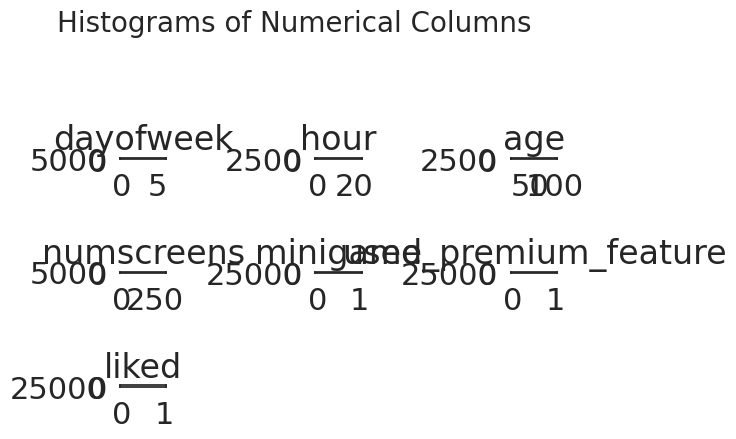

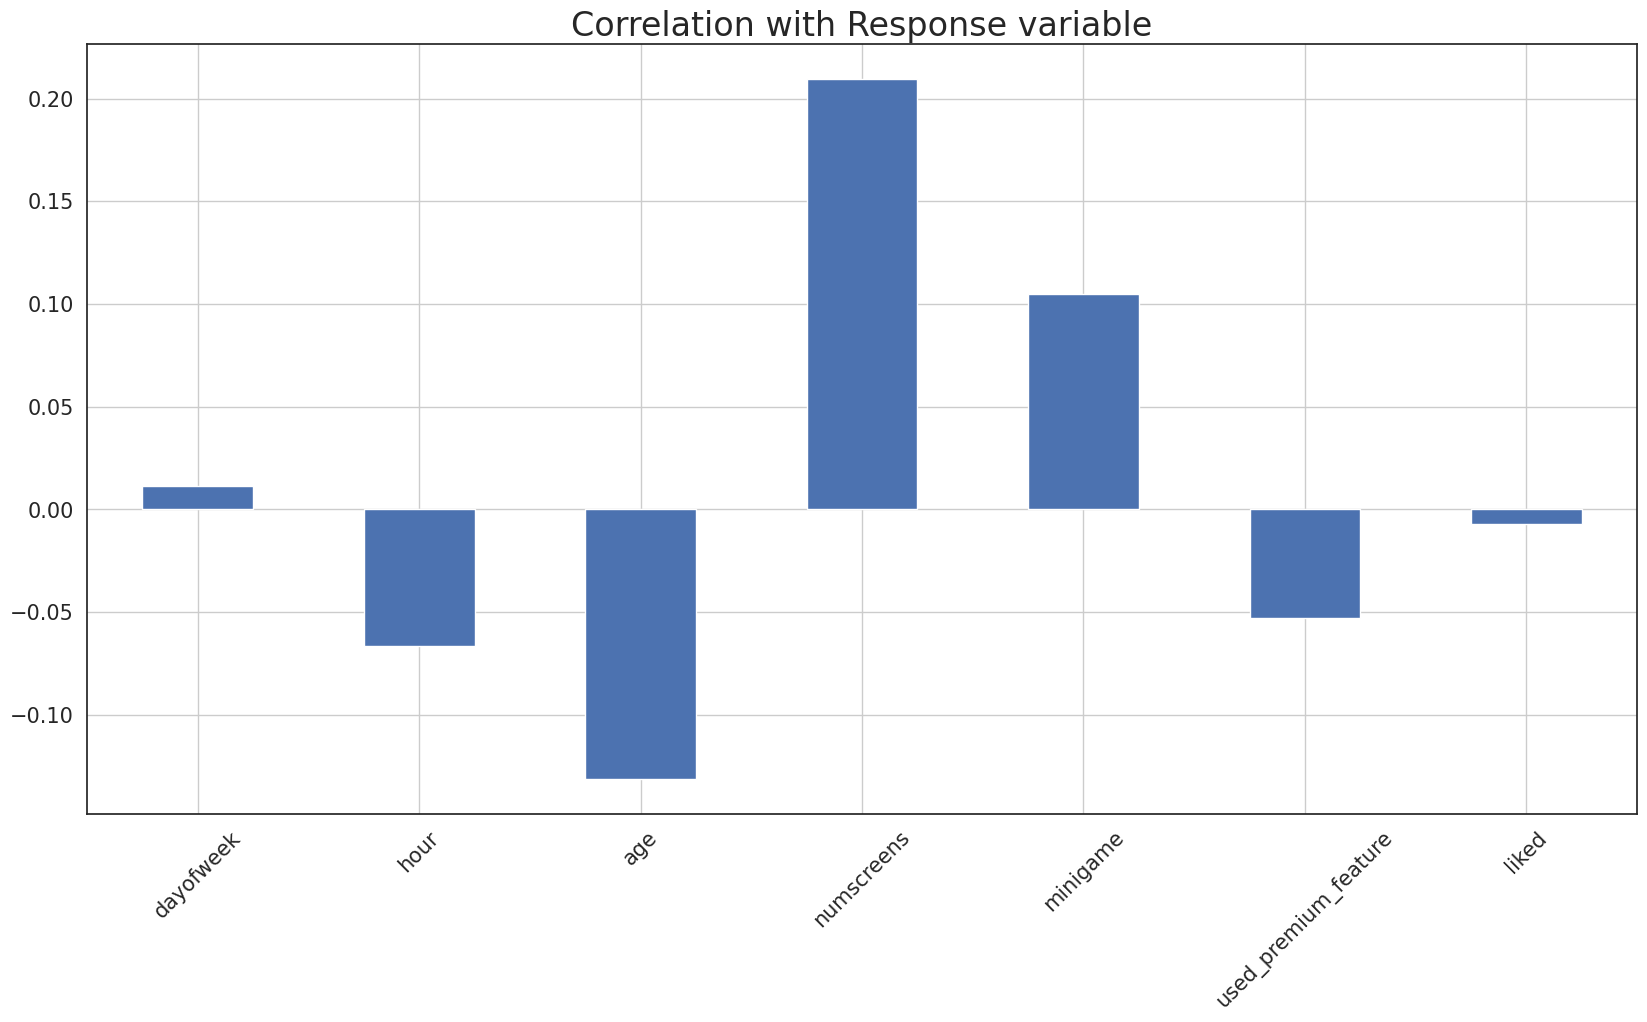

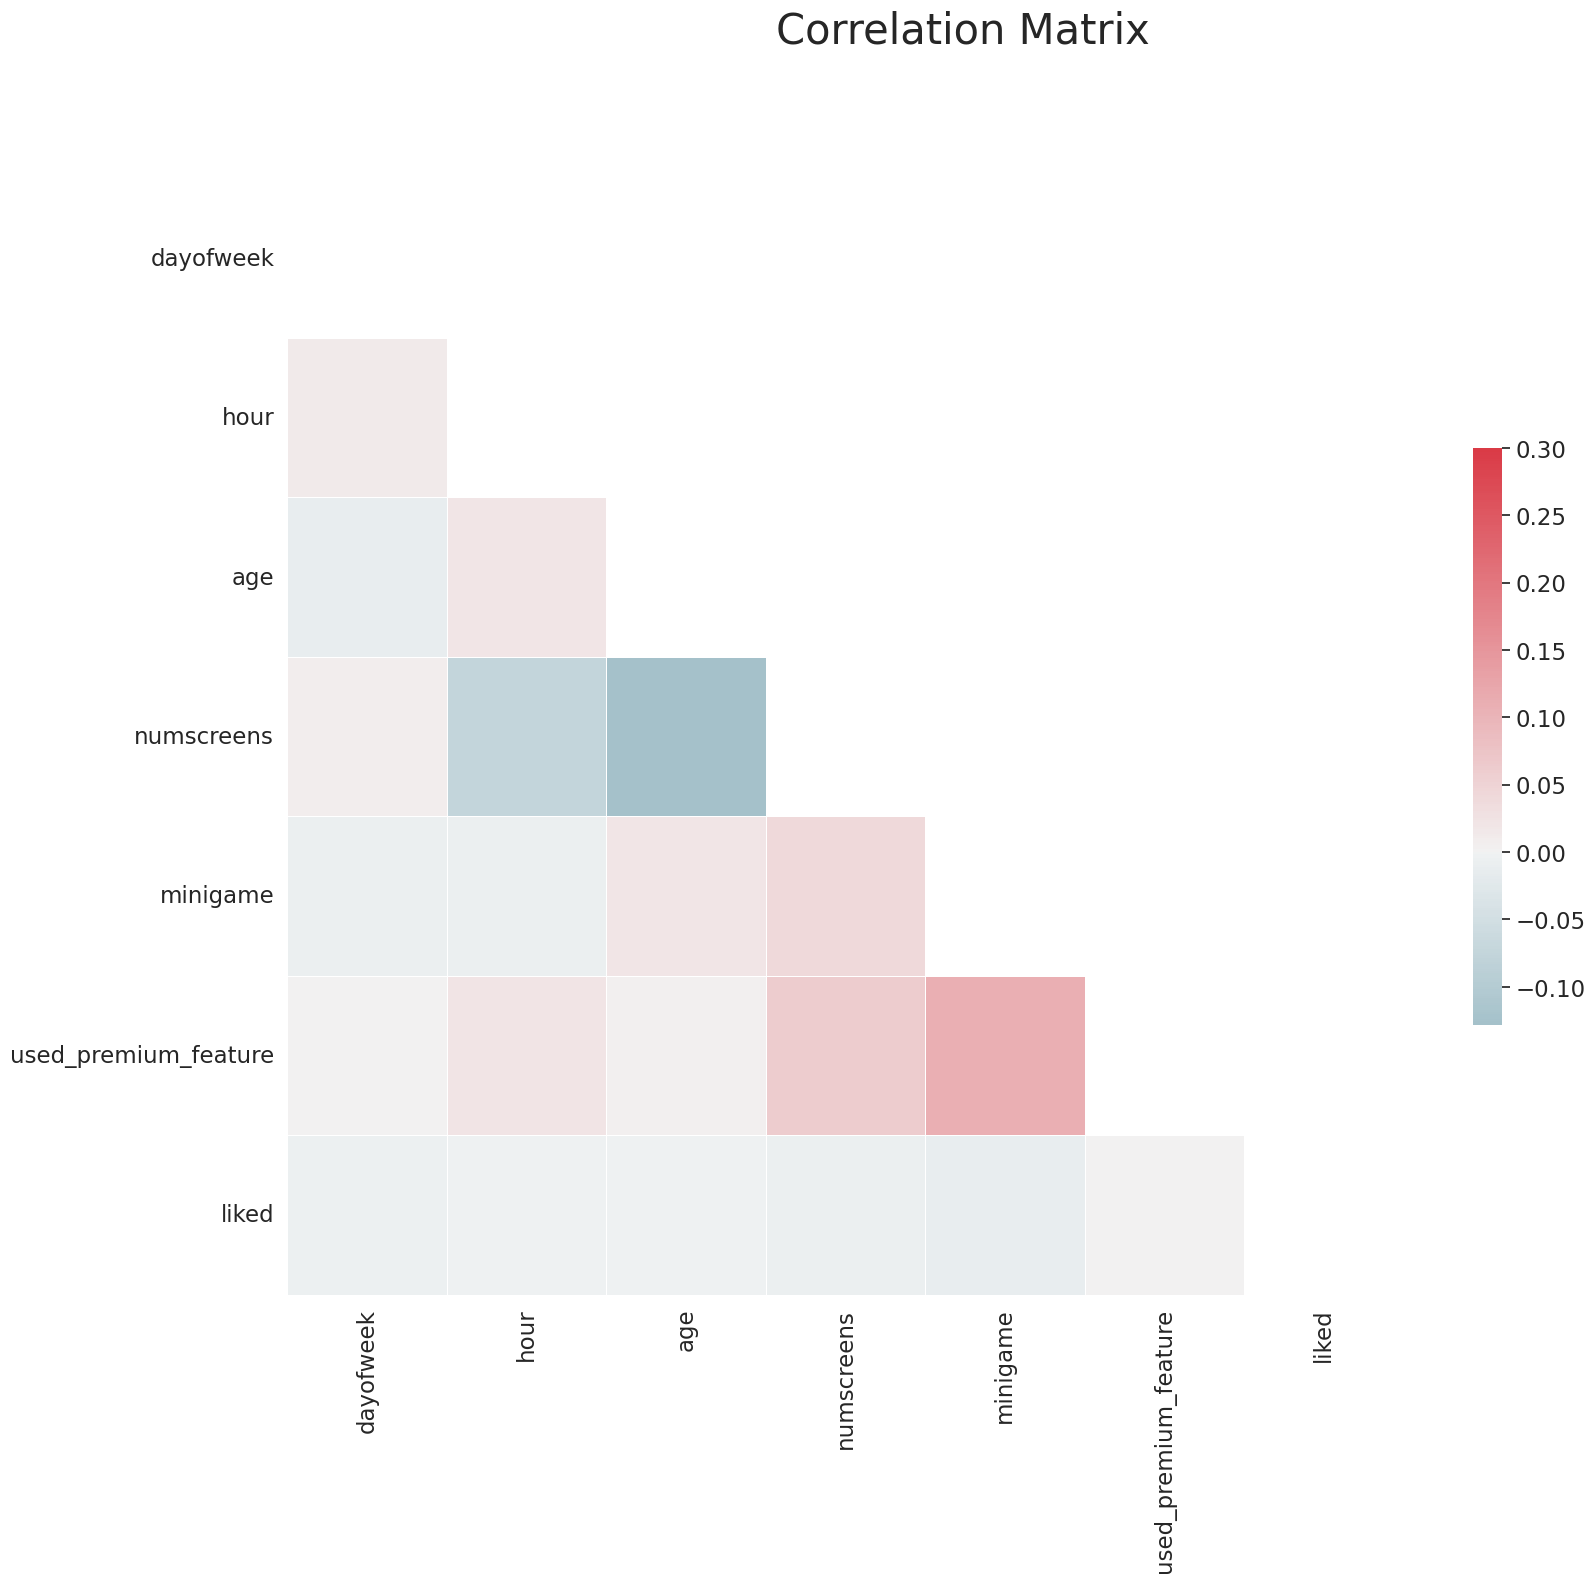

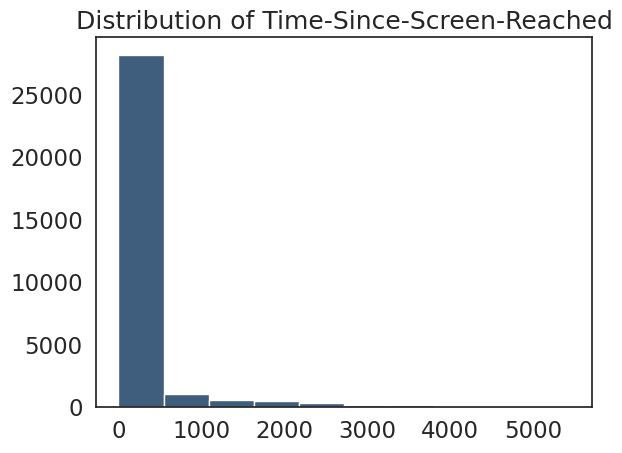

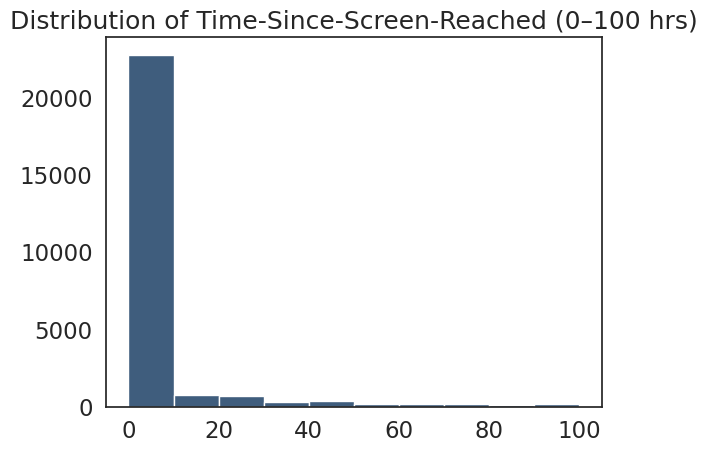

Processed dataset saved to 'new_appdata10.csv'.


In [22]:
#### Importing Libraries ####
import pandas as pd
from dateutil import parser
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

# Load dataset
dataset = pd.read_csv('appdata10.csv')

#### Exploratory Data Analysis (EDA) ####

# Viewing basic dataset information
print(dataset.head(10))
print(dataset.describe())

# Feature cleaning: extracting hour from string
dataset["hour"] = dataset.hour.str.slice(1, 3).astype(int)

# Drop non-numeric/irrelevant columns for plotting
dataset2 = dataset.drop(columns=['user', 'screen_list', 'enrolled_date', 'first_open', 'enrolled'])

# Plot histograms
plt.suptitle('Histograms of Numerical Columns', fontsize=20)
for i in range(1, dataset2.shape[1] + 1):
    plt.subplot(3, 3, i)
    f = plt.gca()
    f.set_title(dataset2.columns.values[i - 1])
    vals = np.size(dataset2.iloc[:, i - 1].unique())
    plt.hist(dataset2.iloc[:, i - 1], bins=vals, color='#3F5D7D')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Correlation with response variable
dataset2.corrwith(dataset['enrolled']).plot.bar(figsize=(20,10),
    title='Correlation with Response variable', fontsize=15, rot=45, grid=True)
plt.show()

# Correlation matrix
sn.set(style="white", font_scale=1.5)
corr = dataset2.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))
f.suptitle("Correlation Matrix", fontsize=30)

# Create heatmap
cmap = sn.diverging_palette(220, 10, as_cmap=True)
sn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
           square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

#### Feature Engineering ####

# Convert date columns
dataset["first_open"] = [parser.parse(row) for row in dataset["first_open"]]
dataset["enrolled_date"] = [parser.parse(row) if isinstance(row, str) else row for row in dataset["enrolled_date"]]

# Time difference in hours
dataset["difference"] = (dataset["enrolled_date"] - dataset["first_open"]) / pd.Timedelta(hours=1)

# Plot time difference
plt.hist(dataset["difference"].dropna(), color='#3F5D7D')
plt.title('Distribution of Time-Since-Screen-Reached')
plt.show()

plt.hist(dataset["difference"].dropna(), color='#3F5D7D', range=[0, 100])
plt.title('Distribution of Time-Since-Screen-Reached (0–100 hrs)')
plt.show()

# Set 'enrolled' to 0 if time since screen is more than 48 hours
dataset.loc[dataset["difference"] > 48, 'enrolled'] = 0

# Drop processed date columns
dataset = dataset.drop(columns=['enrolled_date', 'difference', 'first_open'])

# Process screen_list field
top_screens = pd.read_csv('top_screens.csv').top_screens.values
dataset["screen_list"] = dataset.screen_list.astype(str) + ','

for screen in top_screens:
    dataset[screen] = dataset["screen_list"].str.contains(screen).astype(int)
    dataset["screen_list"] = dataset["screen_list"].str.replace(screen + ",", "", regex=False)

# Count remaining 'Other' screens
dataset['Other'] = dataset["screen_list"].str.count(",")
dataset = dataset.drop(columns=['screen_list'])

# Define screen funnels and create counts
savings_screens = ["Saving1", "Saving2", "Saving2Amount", "Saving4", "Saving5", "Saving6", "Saving7", "Saving8", "Saving9", "Saving10"]
dataset["SavingCount"] = dataset[savings_screens].sum(axis=1)
dataset = dataset.drop(columns=savings_screens)

cm_screens = ["Credit1", "Credit2", "Credit3", "Credit3Container", "Credit3Dashboard"]
dataset["CMCount"] = dataset[cm_screens].sum(axis=1)
dataset = dataset.drop(columns=cm_screens)

cc_screens = ["CC1", "CC1Category", "CC3"]
dataset["CCCount"] = dataset[cc_screens].sum(axis=1)
dataset = dataset.drop(columns=cc_screens)

loan_screens = ["Loan", "Loan2", "Loan3", "Loan4"]
dataset["LoansCount"] = dataset[loan_screens].sum(axis=1)
dataset = dataset.drop(columns=loan_screens)

#### Save Cleaned Dataset ####
dataset.to_csv('new_appdata10.csv', index=False)
print("Processed dataset saved to 'new_appdata10.csv'.")